# <div align="center"><font color='green'> COSC 2673/2793 | Machine Learning  </font></div>
## <div align="center"> <font color='green'> Assignment 2: **Cell Classification**</font></div>

- A well justified evaluation framework.
- Pre-processing the data set to make it suitable for providing to various machine learning algorithms.
- Carefully selected and justified baseline model(s).
- Hyper-parameter setting and tuning to refine the model.
- Analysing model and outputs & interpreting the trained models



This originial study provides 100 histology images related to colon cancer. Most successful approaches to training deep learning models on such histology images perform human-guided feature selection by extracting a small number of patches, via a process known as **patch extraction**, and providing them with patch labels for whether they are cancerous, and its cell type. 

CRCHistoPhenotypes was the basis of our dataset providing 27x27 pixel size patches, and divided into 2 datasets:
 - **Main data**: 
    - 9896 patches
    - Class labels: 'isCancerous' and 'cellType'
- **Extra data**:
    - 10384 patches
    - Class labels: 'isCancerous'





TODO: softmax CNN + NEP for classifying cell types

TODO: transfer learning, use one pre-trained model as basis for 2nd one, aka use extraData classification for mainData classification 
TODO: how to use the extra data:
Another approach is to use the extraData dataset as a source of unlabeled data for semi-supervised learning. In this approach, you can use the extraData dataset to train an unsupervised model, such as an autoencoder, to learn the underlying features of the cell images. Then, you can use the learned features as inputs to a supervised model, which can be trained on the labeled data from the mainData dataset. This approach can help the model learn more robust representations of the cell images, which can lead to better classification performance even with limited labeled data.
TODO: visual transformers?? 16x16 better kernel, more resources to train

TODO:
Eval metrics: Weighted average F1-score, Multi-class AUC, Epithelial Precision (for isCancerous) 


Bibliography:
"Adam: A Method for Stochastic Optimization"
Original paper: http://wrap.warwick.ac.uk/77351/7/WRAP_tmi2016_ks.pdf
https://www.tensorflow.org/api_docs/python/tf/keras/metrics
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/legacy/SGD
https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

original paper (used): http://wrap.warwick.ac.uk/77351/7/WRAP_tmi2016_ks.pdf
rccnet (used): https://arxiv.org/pdf/1810.02797.pdf
https://ieeexplore.ieee.org/document/9715122
https://www.frontiersin.org/articles/10.3389/fmed.2019.00264/full
https://arxiv.org/pdf/1802.00752.pdf
https://ieeexplore.ieee.org/document/8634690
https://arxiv.org/pdf/2009.03878.pdf

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, recall_score
from sklearn.utils import resample, class_weight

import tensorflow
import keras
from keras.initializers import RandomNormal, Zeros
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Activation, add, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Dropout
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import Adam

# for visualizing the model using plot_model
# !pip install pydot

2 datasets:
Main data: used for cell type classification
Full data: Combined main+extra data used for isCancerous classification, and to pretrain for cell type. Drop cell type columns.
We will not merge the datasets yet, as we need to implement our splitting strategy first.


In [14]:
main_data = pd.read_csv('Image_classification_data/data_labels_mainData.csv')
extra_data = pd.read_csv('Image_classification_data/data_labels_extraData.csv')


# convert to string type for future classification
main_data['isCancerous'] = main_data['isCancerous'].astype(str)
extra_data['isCancerous'] = extra_data['isCancerous'].astype(str)
main_data['cellType'] = main_data['cellType'].astype(str)

print(main_data['cellType'].value_counts())
print(main_data['cellTypeName'].value_counts())
print(main_data['isCancerous'].value_counts())

print("Dataset shape")
print(main_data.shape)
print(extra_data.shape)


2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64
0    5817
1    4079
Name: isCancerous, dtype: int64
Dataset shape
(9896, 6)
(10384, 4)


In [15]:

main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [16]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


## Image averaging
Epithelial have  the weakest nuclei positioning, as the center position is blurred, while inflammatory cells have the strongest.
The colour of epithelial cells is a stronger hue of purple, which may contribute to its morphology to distinguish its type.

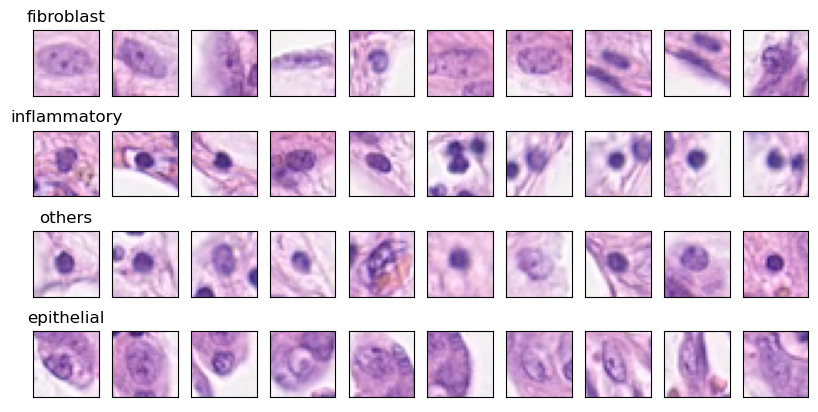

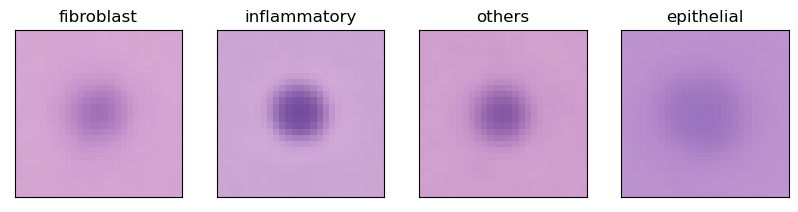

In [17]:
def cell_image(imageName):
    return Image.open('Image_classification_data/patch_images/' + imageName)


rows = 20
# Source: Week 4 Lecture Q and A
def plot_cells(data):
    cell_types = main_data['cellTypeName'].unique()
    plt.figure(figsize=(10,5))
    for i, cell_type in enumerate(cell_types):
        cell_type_data = data[data['cellTypeName'] == cell_type][:10] 
        for j, image_name in enumerate(cell_type_data['ImageName']):
            plt.subplot(len(cell_types), 10, (i*10)+j+1) 
            plt.imshow(cell_image(image_name)) 
            plt.xticks([])
            plt.yticks([])
            if j==0:
                plt.title(cell_type) 
    plt.show()

# Get the average cell image from all cell images 
# filter the data to only include images with the chosen cell type
def plot_image_average(data):
    cell_types = main_data['cellTypeName'].unique()
    plt.figure(figsize=(10,10))
    for i, cell_type in enumerate(cell_types):
        cell_type_data = data[data['cellTypeName'] == cell_type]
        image_arrays = [np.array(cell_image(image_name)) for image_name in cell_type_data['ImageName']]
        average_array = np.mean(image_arrays, axis=0).astype(np.uint8)
        average_image = Image.fromarray(average_array)
        plt.subplot(len(cell_types), 4, i+1) 
        plt.imshow(average_image)
        plt.xticks([])
        plt.yticks([])
        plt.title(cell_type)
    plt.show()

plot_cells(main_data)
plot_image_average(main_data)

"In classification, morphology of nuclei (shape, size, color, and texture) is
necessary to distinguish between different types of them. Raw RGB color intensities which constitute the overall visual
appearance of nuclei were, thus, chosen as input features to
softmax CNN for each patch."
Based on paper, only 1 channel was used for colour intensity. But as mentioned, the colour is also necessary. Epithelial cells appear to have a separate colour entirely, and seems to have a strong correlation to cancerous cells. For this reason, improvements to the CNN's baseline involves making the input shape have 3 channels.

# Get value counts of categorical variables
for column in {'cellTypeName', 'cellType', 'isCancerous'}:
    print(pd.value_counts(data[column]))
data.head()

# Get total unique patients
patients = len(data['patientID'].unique())
print(f"There are {patients} unique patients")

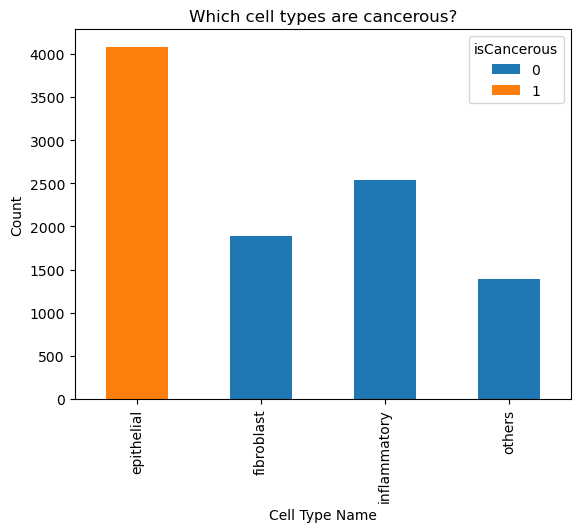

In [18]:
# Stacked bar chart 
grouped_data = main_data.groupby(['cellTypeName', 'isCancerous']).size().reset_index(name='count')
pivoted_data = grouped_data.pivot(index='cellTypeName', columns='isCancerous', values='count')
pivoted_data.plot(kind='bar', stacked=True)
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.title('Which cell types are cancerous?')
plt.show()

The dataset indicates that most cancer cells are epithelial in nature. However, the other cells may still play a role in cancer development. An example of this is inflammation cells causing chronic inflammation, which can damage DNA and other cellular components leading to cancer. [Link](https://www.cancer.gov/news-events/cancer-currents-blog/2022/reducing-inflammation-to-treat-cancer#:~:text=In%20a%20normal%20inflammatory%20response,that%20could%20lead%20to%20cancer)


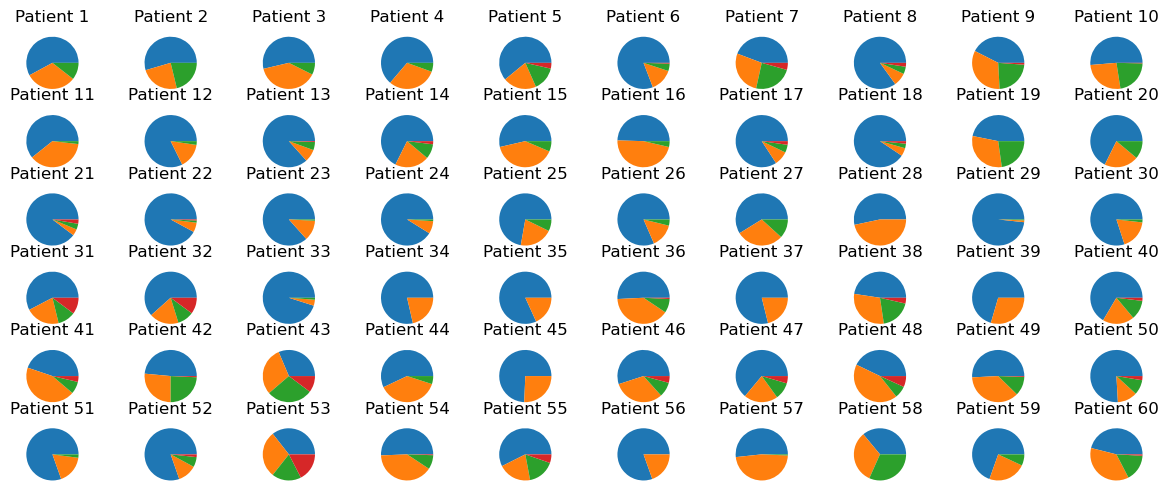

In [19]:

fig = plt.figure(figsize=(15,10))
for i, (patient_id, group) in enumerate(main_data.groupby("patientID")):
    cell_type_counts = group["cellTypeName"].value_counts()
    ax = fig.add_subplot(10,10, i+1)
    
    ax.pie(cell_type_counts)
    ax.set_title(f"Patient {patient_id}")
plt.show()

We have identified that there are 60 unique patients in our dataset, with multiple cells allocated to each patient.
Not every patient has fibroblast or other cells This opens a possibility for uneven distribution of cell types.
To avoid data leakage, we need to group any data for each patient and split the data such that there is no overlap of patient data between train, validation and test sets.
Additionally, we individually split main and extra data with different stratification methods, and then combine them.

One more problem is ensuring that we maintain a rough 60-20-20 split, as certain patients may contain a larger proportion of the dataset, which may cause uneven distribution. This is another reason we specify a random state

Stratified sampling is important so we get a good representation of all cell types in our train, test and val data.
Since all isCancerous cells are also epithelial in the main data, it naturally gets stratified correctly.
Extra data cannot stratify based on cell type, so we stratify on isCancerous instead. 



In [20]:
# 60-20-20 split
def group_split(test_size, data):
    # Reset the index of the DataFrame
    data.reset_index(drop=True, inplace=True)
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

    # Split the data into training and test sets
    for train_idx, test_idx in gss.split(data, groups=data['patientID']):
        train_data = data.loc[train_idx]
        test_data = data.loc[test_idx]
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

def stratified_group_split(test_size, data, strat_col):
    # Reset index for the group shuffle split
    data.reset_index(drop=True, inplace=True)
    
    # Create Stratified Group K-Fold
    stratified_group = StratifiedGroupKFold(n_splits=int(1/test_size), shuffle=True, random_state=15)
    
    for train_idx, test_idx in stratified_group.split(data, y=data[strat_col], groups=data['patientID']):
        train_data = data.loc[train_idx]
        test_data = data.loc[test_idx]
        # We only need the first split
        break 
    
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)


train_main, test_main = group_split(0.2, main_data)
train_main, val_main = group_split(0.25, train_main)

train_extra, test_extra = group_split(0.2, extra_data)
train_extra, val_extra = group_split(0.25, train_extra)

# now we have stratified to the best of our ability
# we can combine isCancerous to get the full dataset
train_full_data = pd.concat([train_main, train_extra]).drop(['cellType', 'cellTypeName'], axis=1)
test_full_data = pd.concat([test_main, test_extra]).drop(['cellType', 'cellTypeName'], axis=1)
val_full_data = pd.concat([val_main, val_extra]).drop(['cellType', 'cellTypeName'], axis=1)
full_data = pd.concat([main_data, extra_data]).drop(['cellType', 'cellTypeName'], axis=1)

# not using stratified
# train_main, test_main = stratified_group_split(0.2, main_data, 'cellTypeName')
# train_main, val_main = stratified_group_split(0.25, train_main, 'cellTypeName')

# train_extra, test_extra = stratified_group_split(0.2, extra_data, 'isCancerous')
# train_extra, val_extra = stratified_group_split(0.25, train_extra, 'isCancerous')

# # now we have stratified to the best of our ability
# # we can combine isCancerous to get the full dataset
# train_full_data = pd.concat([train_main, train_extra]).drop(['cellType', 'cellTypeName'], axis=1)
# test_full_data = pd.concat([test_main, test_extra]).drop(['cellType', 'cellTypeName'], axis=1)
# val_full_data = pd.concat([val_main, val_extra]).drop(['cellType', 'cellTypeName'], axis=1)
# full_data = pd.concat([main_data, extra_data]).drop(['cellType', 'cellTypeName'], axis=1)



MAIN DATA
There are 60 unique patients after splitting, spread across the train, test and validation sets.
There is 0 overlap between the train and test patient data
There is 0 overlap between the train and validation patient data

Train proportion: 0.57
Test proportion: 0.19
Validation proportion: 0.24

FULL DATA
There are 98 unique patients after splitting, spread across the train, test and validation sets.
There is 0 overlap between the train and test patient data
There is 0 overlap between the train and validation patient data

Train proportion: 0.57
Test proportion: 0.20
Validation proportion: 0.23

EXTRA DATA
There are 38 unique patients after splitting, spread across the train, test and validation sets.
There is 0 overlap between the train and test patient data
There is 0 overlap between the train and validation patient data

Train proportion: 0.56
Test proportion: 0.22
Validation proportion: 0.22


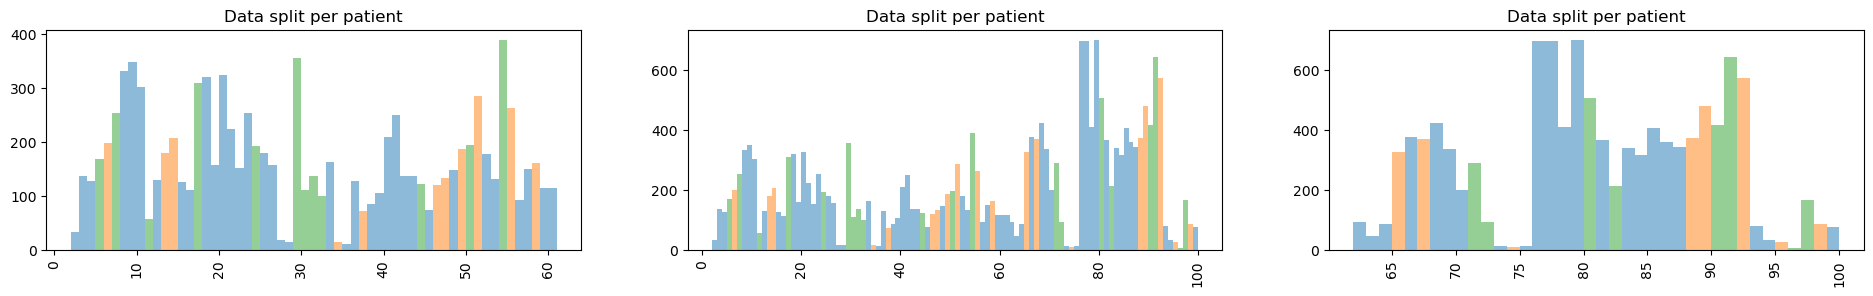

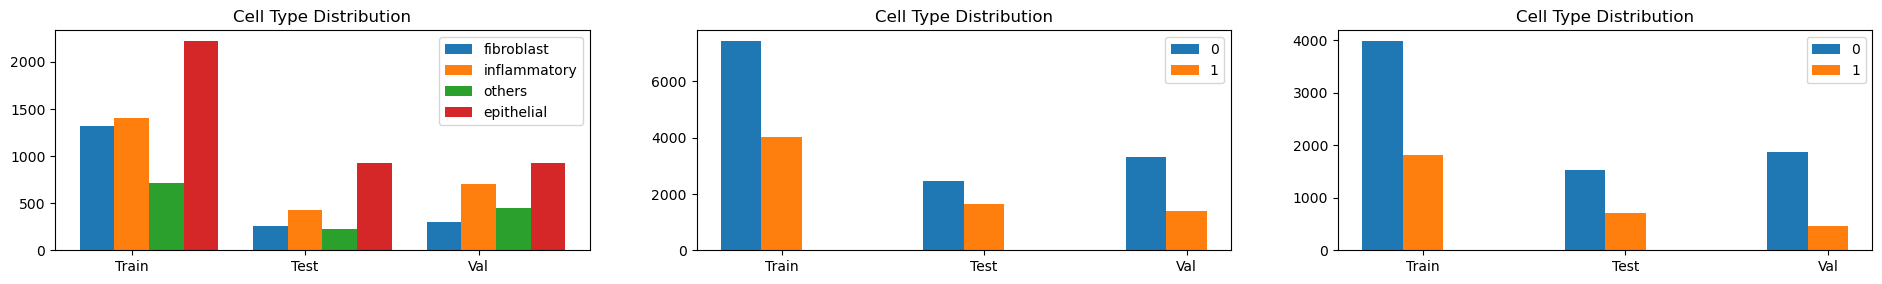

In [21]:
def split_verification(train_data, test_data, val_data, data):   
    train_patients = train_data['patientID'].unique()
    test_patients = test_data['patientID'].unique()
    val_patients = val_data['patientID'].unique()
    all_patients = np.unique(np.concatenate((train_patients, test_patients, val_patients), axis=0))
    print(f"There are {len(all_patients)} unique patients after splitting, spread across the train, test and validation sets.")

    def overlap(train_data, test_data):
        train_patients = train_data['patientID'].unique()
        test_patients = test_data['patientID'].unique()
        return len(np.intersect1d(train_patients, test_patients))

    print(f"There is {overlap(train_data, test_data)} overlap between the train and test patient data")
    print(f"There is {overlap(train_data, val_data)} overlap between the train and validation patient data\n")

    # Calculate the proportions of each dataset
    train_prop = len(train_data) / len(data)
    test_prop = len(test_data) / len(data)
    val_prop = len(val_data) / len(data)

    print(f"Train proportion: {train_prop:.2f}")
    print(f"Test proportion: {test_prop:.2f}")
    print(f"Validation proportion: {val_prop:.2f}")

def plot_patient_data_split(train_data, test_data, val_data, data):
    all_patients = data['patientID'].unique()
    plt.hist(train_data['patientID'], bins = all_patients+1, alpha=0.5)
    plt.hist(test_data['patientID'], bins = all_patients+1, alpha=0.5)
    plt.hist(val_data['patientID'], bins = all_patients+1, alpha=0.5)
    plt.title('Data split per patient')
    plt.xticks(rotation='vertical')

def plot_data_split_strat_col(train_data, test_data, val_data, strat_col):
    datasets = ['Train', 'Test', 'Val']
    bar_width = 0.2

    categories = train_data[strat_col].unique()
    for i, category in enumerate(categories):
        counts = [dataset[strat_col].value_counts().get(category, 0) for dataset in [train_data, test_data, val_data]]
        plt.bar(np.arange(len(datasets)) + i*bar_width, counts, width=bar_width, label=category)

    plt.title('Cell Type Distribution')
    plt.legend()
    plt.xticks(np.arange(len(datasets)) + bar_width, datasets)

print("MAIN DATA")
split_verification(train_main, test_main, val_main, main_data)
print("\nFULL DATA")
split_verification(train_full_data, test_full_data, val_full_data, full_data)
print("\nEXTRA DATA")
split_verification(train_extra, test_extra, val_extra, extra_data)

plt.figure(figsize=(40,20))
plt.subplot(6,5,1)
plot_patient_data_split(train_main, test_main, val_main, main_data)
plt.subplot(6,5,2)
plot_patient_data_split(train_full_data, test_full_data, val_full_data, full_data)
plt.subplot(6,5,3)
plot_patient_data_split(train_extra, test_extra, val_extra, extra_data)

plt.figure(figsize=(40, 20))
plt.subplot(6,5,1)
plot_data_split_strat_col(train_main, test_main, val_main, 'cellTypeName')
plt.subplot(6,5,2)
plot_data_split_strat_col(train_full_data, test_full_data, val_full_data, 'isCancerous')
plt.subplot(6,5,3)
plot_data_split_strat_col(train_extra, test_extra, val_extra, 'isCancerous')

# Modelling Approach

## Evaluation Metrics

#### For Model Improvement
It is important as most of our models may appear to be stagnating while learning, even though the loss is improving. This may take multiple epochs to reveal. To track progress of our models over epochs we use:
- Training/Validation Loss curve
- Training/Validation learning accuracy curve
We can use the accuracy as a general indicator, but especially for isCancerous, it is possible to acheive a very high accuracy by simply predicting everything as non-cancerous.

Note that epithelial and cancerous cells are heavily disproportionate to the rest of the data. This is especially useful if the model appears to predict well, but in reality is only predicting one class well. Handling *class imbalance* is a way to ensure that our model works beyond just the disproportionate amount of epithelial cells in our main data. To visualize how generalized the model is over all types of data, we use:
- confusion matrix

#### For Test Data
For our test data, we use the following metrics:
- weighted average f1 score
- multiclass ROC AUC score
- other f1 score




In [71]:
# sourced from Week 10 demo
def train_val_accuracy(history):

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'r--')
    plt.plot(history.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], 'r--')  # Replace train_accuracy with 'categorical_accuracy'
    plt.plot(history.history['val_accuracy'], 'b--')  # Replace val_accuracy with 'val_categorical_accuracy'
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_metrics(generator, model, y_col):
    # Get the labels in the order they were fed to the model
    class_indices = generator.class_indices
    categories = [k for k, _ in sorted(class_indices.items(), key=lambda item: item[1])]

    pred_probs = model.predict(generator)
    pred_labels = np.round(pred_probs) if y_col == 'isCancerous' else np.argmax(pred_probs, axis=1)
    true_labels = generator.classes

    # Plot the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    figsize = (4,4)
    plt.figure(figsize=figsize)
    font_size = min(14, max(5, int(figsize[0] * 1.5)))
    plt.xticks(fontsize=font_size) 
    plt.yticks(fontsize=font_size)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    weighted_f1 = f1_score(true_labels, pred_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')
    scores = [weighted_f1, roc_auc]
    # also add iscancerous recall if we are classifying it
    # important to ensure no failed classificatino of cancer cells
    if y_col == 'isCancerous':
        is_cancerous_recall = recall_score(true_labels, pred_labels, pos_label=1)
        print(f"isCancerous recall: {is_cancerous_recall}")
        scores = [weighted_f1, roc_auc, is_cancerous_recall]
    print(f"Weighted average F1-score: {weighted_f1}")
    print(f"Multiclass AUC: {roc_auc}")
    return scores

# Classifying Cell Type

## Baseline: softmax_CNN
We use a similar structure to the softmaxCNN_IN27 proposed in the original paper. We will retain most of its pre-processing and fine tuning steps in the final model, to replicate the original model as closely as possible.

## Data Augmentation
"For both networks, we arbitrary rotated patches (0◦, 90◦, 180◦, 270◦) and flipped them along vertical or horizontal axis to alleviate the rotation-variant problem of the input features."

In [22]:
# baseline colour perturbation specified
def perturb_color(img):
    img_uint8 = (img * 255).astype('uint8')
    img = Image.fromarray(img_uint8)
    img = img.convert('HSV')
    rH = np.random.uniform(0.95, 1.05)
    rS = np.random.uniform(0.9, 1.1)
    rV = np.random.uniform(0.9, 1.1)
    img_hsv = np.array(img)
    img_hsv[..., 0] = np.clip(img_hsv[..., 0] * rH, 0, 179)
    img_hsv[..., 1] = np.clip(img_hsv[..., 1] * rS, 0, 255)
    img_hsv[..., 2] = np.clip(img_hsv[..., 2] * rV, 0, 255)
    img_rgb = Image.fromarray(img_hsv, mode='HSV').convert('RGB')
    img_array = np.array(img_rgb) / 255.0
    return img_array

As there are too many images to open directly, we need a generator function to help us.
By specifying the column as 'isCanerous' or 'cellTypeName' the generator chooses the correct Class Mode, and the train and validation data.
Categorical class mode, but pass the string labels in, as Keras will handle one-hot encoding. This is better than using sparse.
shuffle allows us to plot metrics by consistent prediction on the model
extra_data_only allows us to change the dataset for training for isCancerous accuracy. If we need to pretrain for cellType, we should only use extra_data to avoid data leakage.

In [23]:

def generator(batch_size, y_col, shuffle=True, extra_data_only=False, oversampler=None):
    # depending on the task, we specify how to classify, as well as what data to pass in
    if y_col == 'isCancerous':
        class_mode = 'binary'
        gen_train_data = train_extra if extra_data_only else train_full_data
        gen_val_data = val_extra if extra_data_only else val_full_data
        gen_test_data = test_extra if extra_data_only else test_full_data

        if oversampler:
            gen_train_data = oversampler(gen_train_data)
    elif y_col == 'cellTypeName' or y_col == 'cellType':
        # Keras will handle one-hot encoding for us
        class_mode = 'sparse'
        gen_train_data = train_main
        gen_val_data = val_main
        gen_test_data = test_main


    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        data_format='channels_last', 
        rotation_range=90, 
        horizontal_flip=True, 
        vertical_flip=True,
    #     preprocessing_function=lambda x: perturb_color(x)
    )

    val_datagen = ImageDataGenerator(
        rescale=1./255, 
        data_format='channels_last'
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255, 
        data_format='channels_last'
    )

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=gen_train_data,
            directory='Image_classification_data/patch_images',
            x_col="ImageName",
            y_col=y_col,
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode=class_mode,
            # must set shuffle to false for evaluation
            shuffle=shuffle
    )

    val_generator = val_datagen.flow_from_dataframe(
            dataframe=gen_val_data,
            directory='Image_classification_data/patch_images',
            x_col="ImageName",
            y_col=y_col,
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode=class_mode,
            shuffle=shuffle
    )

    test_generator = test_datagen.flow_from_dataframe(
            dataframe=gen_test_data,
            directory='Image_classification_data/patch_images',
            x_col="ImageName",
            y_col=y_col,
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode=class_mode,
            shuffle=shuffle
    )
    return train_generator, val_generator, test_generator


This is based on the located at (http://wrap.warwick.ac.uk/77351/7/WRAP_tmi2016_ks.pdf)

**Model training details employed (based on Section VI C):**
- "The networks were trained using stochastic gradient descent with momentum 0.9 and weight decay 5 × 10−4 for 120 epochs. We annealed the learning rate, starting from 10−2 for the first 60 epochs, then 10−3 for the next 40 epochs, and 10−4 for the last 20 epochs." 
  - SGD for optimizer with custom momentum, weight decay and lr_scheduler.
- "The optimal networks for softmax CNN were selected based on the classification error on the validation set, respectively."
- "In both networks, a rectified linear unit (ReLU)
activation function [32] was used after each convolution layer
and the first two fully-connected layers (1st, 3rd, 5th and 6th
layer)."
- "To avoid over-fitting, dropout [33] was implemented in
the first-two fully-connected layers (5th and 6th layer, after
ReLU is applied) with a dropout rate of 0.2."
- Softmax CNN for the output layer

We took the CNN layout and replicated it here, accounting for the dropout and relu specifications.

| Layer | Type       | Filter Dimensions | Input/Output Dimensions |
|-------|------------|------------------|-------------------------|
| 0     | Input      | -                | 27 X 27 X 1             |
| 1     | Convolution| 4 X 4 X 1 X 36         | 24 X 24 X 36            |
| 2     | Max-pooling| 2 X 2            | 12 X 12 X 36            |
| 3     | Convolution| 3 X 3 X 36 X 48   | 10 X 10 X 48            |
| 4     | Max-pooling| 2 X 2            | 5 X 5 x 48              |
| 5     | Fully-connected | 5 X 5 X 48 X 512   | 1 x 512                 |
| 6     | Fully-connected | 1 X 1 X 512 X 512  | 1 X 512                 |
| 7     | Fully-connected | 1 X 1 X 512 X 4    | 1 X 4                   |

**Considerations:** input dimension of 27x27x1 implies only 1 channel,  while the RGB images have 3. This implies the CNN can only see the intensity of the image, but not the colour information, which is important for determining the cell type.

In [110]:
def softmax_CNN(y_col, input_shape=(27,27,1), optimizer='SGD', fully_connected_units=512, dropout=0.2, keepLastLayer = True):

    if y_col == 'isCancerous':
        units = 1
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    elif y_col == 'cellTypeName' or y_col == 'cellType':
        units = 4
        activation = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        
    model = Sequential()
    # Convolutional Layer 1 (4x4x1x36)
    model.add(Conv2D(filters=36, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
    # Max Pooling Layer 2 (2x2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Convolutional Layer 3 (3x3x36x48)
    model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='relu'))
    # Max Pooling Layer 4 (2x2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # # flatten H X W x Channels to 1D 
    model.add(Flatten())
    # Fully Connected Layer 5 (5x5x48x512)
    model.add(Dense(units=fully_connected_units, activation='relu'))
    model.add(Dropout(dropout))
    if keepLastLayer:
        # Fully Connected Layer 6 (1x1x512x512)
        model.add(Dense(units=fully_connected_units, activation='relu'))
        model.add(Dropout(dropout))
    # Output Layer 7 (1x1x512x4)
    model.add(Dense(units=units, activation=activation))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model



Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/30
178/178 [==============================] - 15s 77ms/step - loss: 1.3327 - accuracy: 0.3841 - val_loss: 1.3426 - val_accuracy: 0.3898 - lr: 0.0100
Epoch 2/30
178/178 [==============================] - 13s 74ms/step - loss: 1.3138 - accuracy: 0.3922 - val_loss: 1.3369 - val_accuracy: 0.3898 - lr: 0.0100
Epoch 3/30
178/178 [==============================] - 13s 73ms/step - loss: 1.2988 - accuracy: 0.3943 - val_loss: 1.3169 - val_accuracy: 0.4120 - lr: 0.0100
Epoch 4/30
178/178 [==============================] - 14s 76ms/step - loss: 1.2528 - accuracy: 0.4407 - val_loss: 1.2733 - val_accuracy: 0.5683 - lr: 0.0100
Epoch 5/30
178/178 [==============================] - 13s 74ms/step - loss: 1.2054 - accuracy: 0.4842 - val_loss: 1.1671 - val_accuracy: 0.4430 - lr: 0.0100
Epoch 6/30
178/178 [============

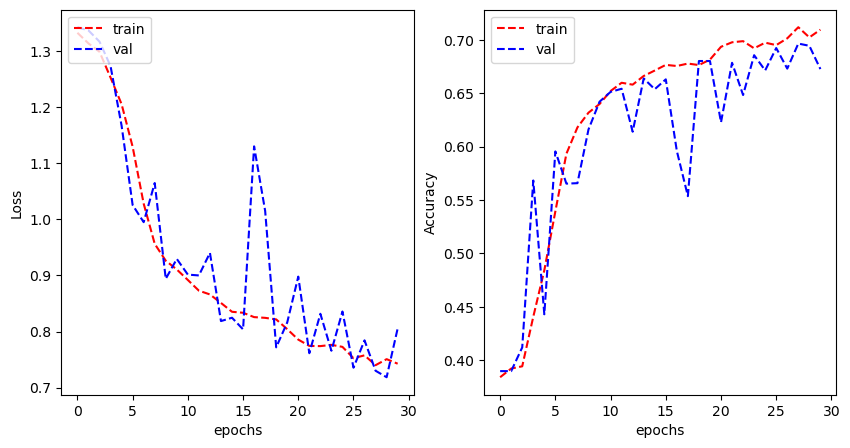

Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
75/75 [==============================] - 1s 14ms/step


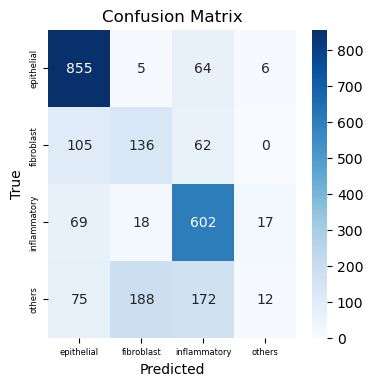

Weighted average F1-score: 0.6119822774086684
Multiclass AUC: 0.8595985263944856
58/58 [==============================] - 1s 14ms/step


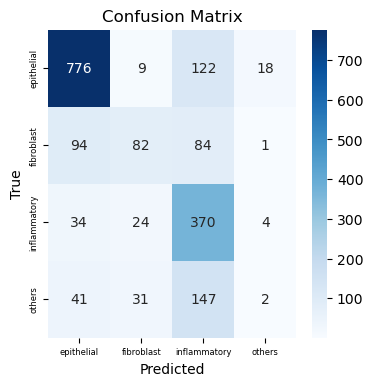

Weighted average F1-score: 0.6271031999146663
Multiclass AUC: 0.8299291694011636


In [112]:
batch_size = 32
y_col = 'cellTypeName'
# the paper specifies different learning rates based on epoch
def lr_scheduler(epoch):
    if epoch < 60:
        return 0.01
    elif epoch < 100:
        return 0.001
    else:
        return 0.0001
# the paper specifies a custom SGD rate
sgd = keras.optimizers.SGD(decay=0.0005, momentum=0.9)

baseline = softmax_CNN(y_col)
train_generator, val_generator, test_generator = generator(batch_size, y_col)
baseline_history = baseline.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[LearningRateScheduler(lr_scheduler)])
train_val_accuracy(baseline_history)

# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)
plot_metrics(val_generator, baseline, y_col)
baseline_scores = plot_metrics(test_generator, baseline, y_col)

> **Observations:**
> - the drops in the learning curve are likely from `other` cell type being introduced in the batch.
> - This model does the best at fitting to the training data.
> - One channel is not enough data, especially for classifying epithelial cells of a differrent colour. All 3 channels need to be passed in.
> - use adam instead of SGD (automatically adapts learning rate, rather than manually annealing it), discovered only a year before this papers publication in 2015. Future CNN implementations also use this.
> - The RCCNet paper mentions reducing the Learning rate on plateau. As the loss tends to stagnate, we will use it here.
> - The low Multi class AUC score indicates the model falls victim to **class imbalance** on the 'others' cell type. One way to avoid this is to adjust weights, however, we want to minimize the misclassification of epithelial cells, which are important for detecting cancer.


Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/30
178/178 [==============================] - 15s 77ms/step - loss: 1.0330 - accuracy: 0.5770 - val_loss: 0.8502 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 2/30
178/178 [==============================] - 13s 70ms/step - loss: 0.7855 - accuracy: 0.6949 - val_loss: 0.7859 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 3/30
178/178 [==============================] - 13s 73ms/step - loss: 0.7332 - accuracy: 0.7168 - val_loss: 0.6879 - val_accuracy: 0.7234 - lr: 0.0010
Epoch 4/30
178/178 [==============================] - 12s 69ms/step - loss: 0.7370 - accuracy: 0.7115 - val_loss: 0.7155 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 5/30
178/178 [==============================] - 12s 69ms/step - loss: 0.7027 - accuracy: 0.7276 - val_loss: 0.7515 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 6/30
177/178 [============

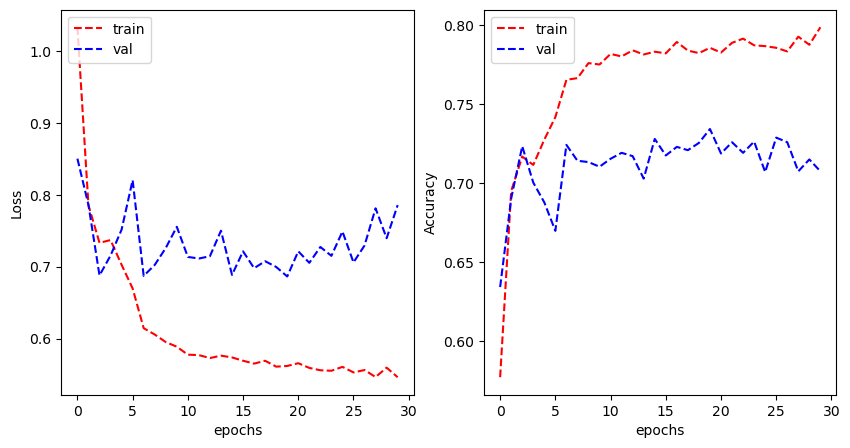

Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
75/75 [==============================] - 3s 31ms/step


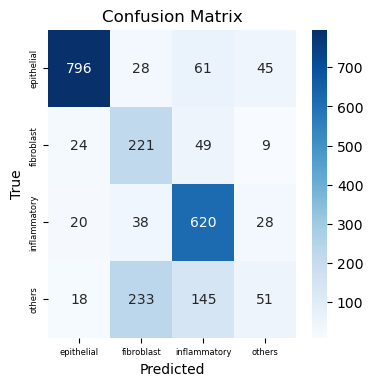

Weighted average F1-score: 0.6802676305096553
Multiclass AUC: 0.8746547550127418
58/58 [==============================] - 2s 32ms/step


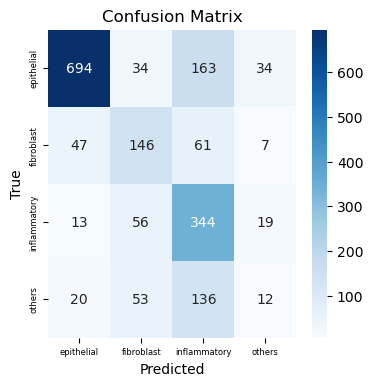

Weighted average F1-score: 0.638381335658829
Multiclass AUC: 0.8491967305942671


In [111]:
batch_size = 32
# the input shape will now take all 3 RGB channels
# no need to manually anneal learning rate, use ADAM
cnn_improved = softmax_CNN(y_col, input_shape=(27,27,3), optimizer='adam')
train_generator, val_generator, _ = generator(batch_size, y_col)
# the rcc net paper devises this to modify the learning rate when the loss plateaus
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3, verbose=1, min_lr=6e-5)
cnn_improved_history = cnn_improved.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[lr_scheduler])
train_val_accuracy(cnn_improved_history)

# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)
plot_metrics(val_generator, cnn_improved, y_col)
cnn_improved_scores = plot_metrics(test_generator, cnn_improved, y_col)


>Observations:
> - The model is overfitting to the training data. The 3 channels offer too much complexity for this CNN.
> - The true positive rates of epithelial and inflammatory cells are great. 
> - This comes at the cost of misclassifying other cell types, and more cells getting predicted as others.
> - our training data has a much higher distribution of other cells.
> - This is an indication of requiring better sampling or more data by using extraData

Due to the erratic learning curve, it is possible that the model is not complex enough to handle 3 channels. The learning rate is  The next iteration will go back to using 1 channel.

Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/30
178/178 [==============================] - 16s 81ms/step - loss: 1.1260 - accuracy: 0.5140 - val_loss: 0.9928 - val_accuracy: 0.6081 - lr: 0.0010
Epoch 2/30
178/178 [==============================] - 13s 74ms/step - loss: 0.8940 - accuracy: 0.6385 - val_loss: 0.9025 - val_accuracy: 0.6459 - lr: 0.0010
Epoch 3/30
178/178 [==============================] - 14s 79ms/step - loss: 0.7846 - accuracy: 0.6868 - val_loss: 0.7563 - val_accuracy: 0.6668 - lr: 0.0010
Epoch 4/30
178/178 [==============================] - 13s 75ms/step - loss: 0.7572 - accuracy: 0.7011 - val_loss: 0.7591 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 5/30
178/178 [==============================] - 13s 74ms/step - loss: 0.7324 - accuracy: 0.7099 - val_loss: 0.7356 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 6/30
178/178 [============

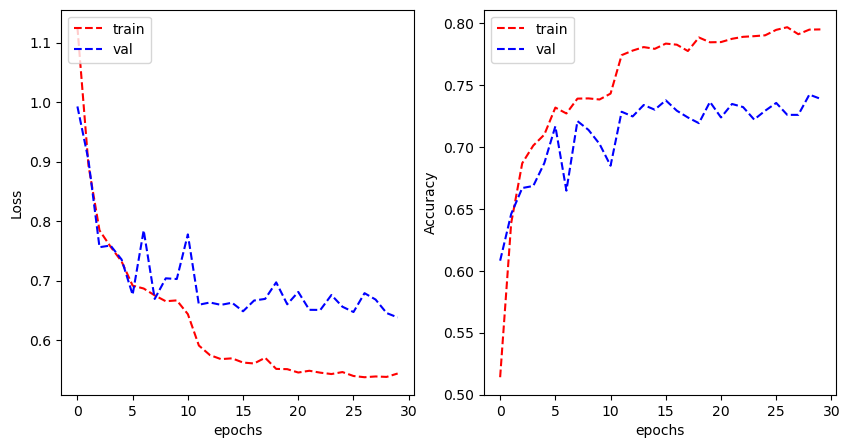

Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
75/75 [==============================] - 3s 31ms/step


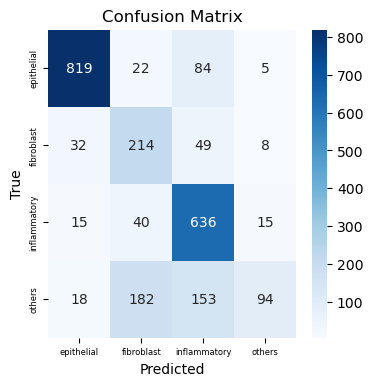

Weighted average F1-score: 0.7164662512511295
Multiclass AUC: 0.9184269280900026
58/58 [==============================] - 2s 33ms/step


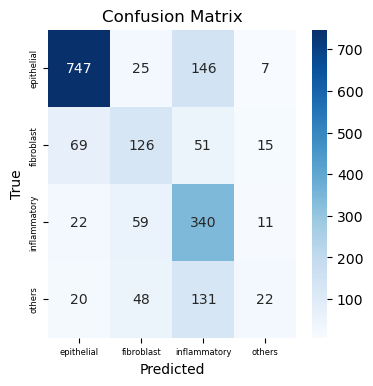

Weighted average F1-score: 0.6547497878052814
Multiclass AUC: 0.8598719373839743


In [109]:
# the input shape will now take all 3 RGB channels
# no need to manually anneal learning rate, use ADAM
cnn_improved = softmax_CNN(y_col, input_shape=(27,27,1), optimizer='adam')
train_generator, val_generator, _ = generator(batch_size, y_col)
# the rcc net paper devises this to modify the learning rate when the loss plateaus
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3, verbose=1, min_lr=6e-5)
cnn_improved_history = cnn_improved.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[lr_scheduler])
train_val_accuracy(cnn_improved_history)

# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)
plot_metrics(val_generator, cnn_improved, y_col)
cnn_improved_scores = plot_metrics(test_generator, cnn_improved, y_col)

> Observations:
> - This model performs better than the previous one, as the validation accuracy curve doesn't drop, indicating that lower complexity works better for this model.
> - This model predicts `other` cell type slightly better, as indicated by the highest Multi class AUC score.
> - This contributes the highest weighted f1-score, as their distributions are also the highest.
> - However the baseline appears the best when it comes to fitting to the data.

This indicates a need for a better model with higher complexity, able to deal with all 3 RGB channels. For this, we will use a new model  **RCC NeT** that is capable of taking this as input.

## Model 2: RCCNet

This model hopes to improve on the performance of the previous model as it claims is not deep
enough as compared to the complexity of the histology image dataset. It overcomes this by providing 7 trainable layers with 1512868 learnable parameters to outperform it in classification. this also helps with its generalization, providing the least amount of over fitting.

**Model training details employed:**
- The initial value of the learning rate is considered as 6 × 10−5, and iteratively decreased with a factor of √0.1 if there is no improvement in validation loss during training. (use LR Scheduler)
- The rectified linear unit (ReLU) [9] is employed as the
activation function in all the implemented models. 
- To reduce over fitting, dropout [27] is used after ReLU of each fully
connected layer with a rate of 0.5 and Batch Normalization
[28] used after every trainable layer(except last F C layer)
after ReLU is applied. 
All the models are trained for 500
epochs using Adam optimizer [29] with β1 = 0.9, β2 = 0.99,
and decay = 1×10−6



In [52]:
def rcc_net(y_col, optimizer='adam', fully_connected_units=512, dropout = 0.5, keepAllLayers = True):
    if y_col == 'isCancerous':
        units = 1
        # optimal for binary data
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    elif y_col == 'cellTypeName' or y_col == 'cellType':
        units = 4
        activation = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        
    model = Sequential()
    
    # Convolutional Layer 1 (32x32x32)
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(27,27,3), activation='relu'))
    model.add(BatchNormalization())
    
    # Convolutional Layer 2 (30x30x32)
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    
    # Pooling Layer 1 (15x15x32)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    if keepAllLayers:
        # Convolutional Layer 3 (15x15x64)
        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        
        # Convolutional Layer 4 (13x13x64)
        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        model.add(BatchNormalization())
    
        # Pooling Layer 2 (6x6x64)
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten H X W x Channels to 1D 
    model.add(Flatten())
    
    if keepAllLayers:
        # Fully Connected Layer 1 (1x512)
        model.add(Dense(units=fully_connected_units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    
    # Fully Connected Layer 2 (1x512)
    model.add(Dense(units=fully_connected_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    # Fully Connected Layer 3 (1x4)
    model.add(Dense(units=units, activation=activation))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model


Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/5
178/178 [==============================] - 10s 51ms/step - loss: 1.1278 - accuracy: 0.6452 - val_loss: 4.8365 - val_accuracy: 0.3898
Epoch 2/5
178/178 [==============================] - 9s 51ms/step - loss: 0.8277 - accuracy: 0.6935 - val_loss: 3.2729 - val_accuracy: 0.4225
Epoch 3/5
178/178 [==============================] - 9s 50ms/step - loss: 0.7370 - accuracy: 0.7274 - val_loss: 1.3579 - val_accuracy: 0.5960
Epoch 4/5
178/178 [==============================] - 9s 49ms/step - loss: 0.6881 - accuracy: 0.7383 - val_loss: 1.3605 - val_accuracy: 0.4866
Epoch 5/5
178/178 [==============================] - 9s 50ms/step - loss: 0.6442 - accuracy: 0.7530 - val_loss: 0.8484 - val_accuracy: 0.7142


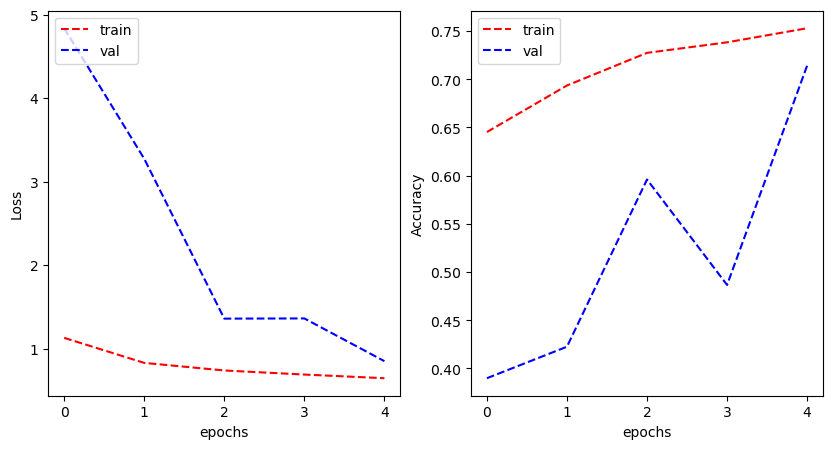

Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
75/75 [==============================] - 1s 18ms/step


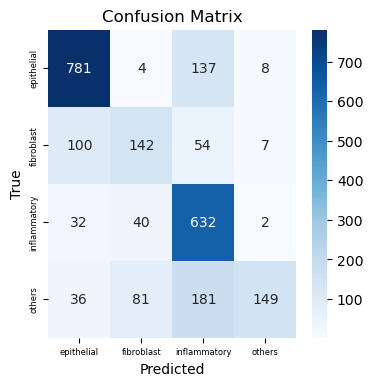

Weighted average F1-score: 0.6970808541575517
Multiclass AUC: 0.8872062196767452
58/58 [==============================] - 1s 18ms/step


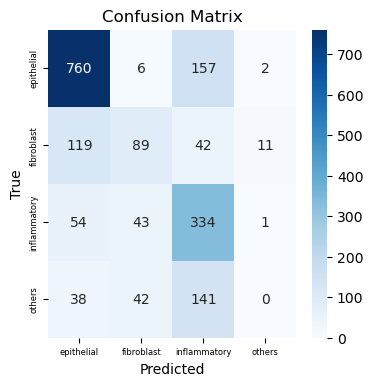

Weighted average F1-score: 0.6024071483894664
Multiclass AUC: 0.8178491526361693


In [100]:

batch_size = 32
y_col = 'cellTypeName'
rcc = rcc_net(y_col)
train_generator, val_generator, _ = generator(batch_size, y_col)

rcc_history = rcc.fit(train_generator, epochs=5, validation_data=val_generator)
train_val_accuracy(rcc_history)

# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)
plot_metrics(val_generator, rcc, y_col)
rcc_scores = plot_metrics(test_generator, rcc, y_col)

> Observations:
> - The above seems to have a very erratic validation accuracy. This may be from coming across batches with `other` data, as this data is scarce.
> - The confusion matrix shows overprediction of `other` types.
> - The model may be too complex for our data.


**Adjusting weight imbalance** should help improve this, as it will avoid overclassifying everything as epithelial.
We can also reduce batch size to help generalize better.

Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/5
45/45 [==============================] - 10s 195ms/step - loss: 1.4239 - accuracy: 0.5817 - val_loss: 2.7798 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 2/5
45/45 [==============================] - 8s 184ms/step - loss: 1.0224 - accuracy: 0.6708 - val_loss: 7.4991 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 3/5
45/45 [==============================] - 8s 180ms/step - loss: 0.9271 - accuracy: 0.6879 - val_loss: 10.3917 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 4/5
45/45 [==============================] - 9s 193ms/step - loss: 0.8246 - accuracy: 0.7156 - val_loss: 12.8177 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 5/5
45/45 [==============================] - 8s 184ms/step - loss: 0.7583 - accuracy: 0.7410 - val_loss: 14.0182 - val_accuracy: 0.3898 - lr: 0.0010


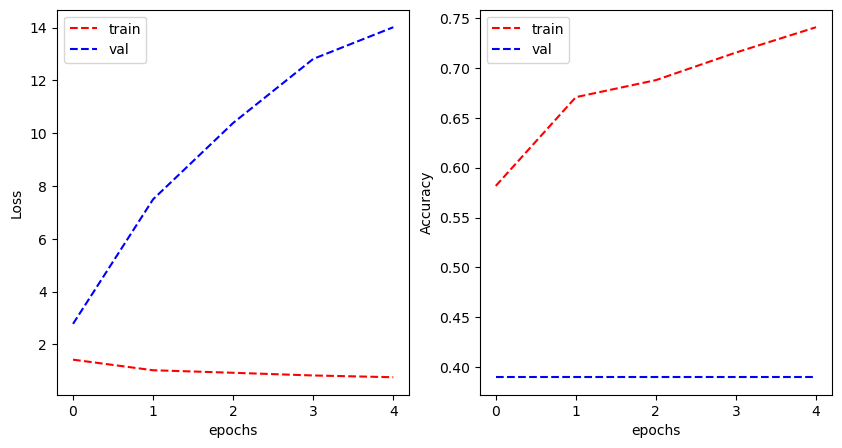

Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
19/19 [==============================] - 1s 66ms/step


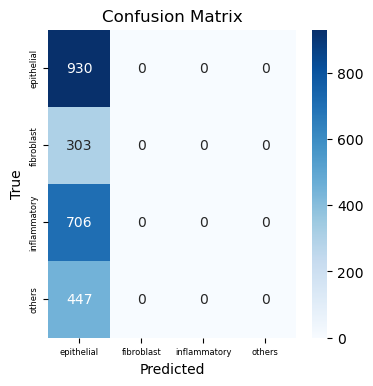

Weighted average F1-score: 0.21863059240826815
Multiclass AUC: 0.6142737040764958
15/15 [==============================] - 1s 64ms/step


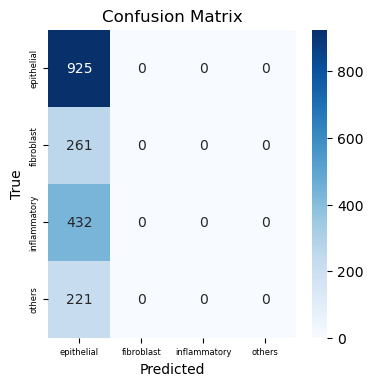

Weighted average F1-score: 0.3366616853524968
Multiclass AUC: 0.6571838850586922


In [90]:
batch_size = 128
def balanced_weights(train_generator): 
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    return dict(enumerate(class_weights))
    

rcc_improved = rcc_net(y_col, optimizer = Adam(beta_1=0.9, beta_2=0.99, decay=1e-6))
train_generator, val_generator, _ = generator(batch_size, y_col)

lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=5, verbose=1, min_lr=6e-5)
rcc_improved_history = rcc_improved.fit(train_generator, epochs=5, validation_data=val_generator, class_weight=balanced_weights(train_generator), callbacks=[lr_scheduler])
train_val_accuracy(rcc_improved_history)
# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)
plot_metrics(val_generator, rcc_improved, y_col)
rcc_improved_scores = plot_metrics(test_generator, rcc_improved, y_col)


# Classifying isCancerous

We will use the model with the best weighted F1-score as the baseline. This is because this also implies the highest epithelial score. From our EDA visualizations prior, we also know that isCancerous cells are included here. So this is the best model for classifying isCancerous features.

## Model 1: Softmax_CNN

The activation function in the final Dense layer should be 'sigmoid' instead of 'softmax'. The sigmoid function is used for binary classification because it squashes its input to the range [0, 1], which can be interpreted as a probability of the positive class.


In [ ]:
batch_size = 128
y_col = 'isCancerous'
cancer_baseline = softmax_CNN(y_col, input_shape=(27,27,3), optimizer='adam', fully_connected_units = 512, dropout = 0.2)
train_generator, val_generator, test_generator = generator(batch_size, y_col)
cancer_baseline_history = cancer_baseline.fit(train_generator, epochs=10, validation_data=val_generator)
train_val_accuracy(cancer_baseline_history)
# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)

plot_metrics(val_generator, cancer_baseline, y_col)
cancer_baseline_scores = plot_metrics(test_generator, cancer_baseline, y_col)

# Transfer Learning

Now that we have fine tuned models, we can consider using transfer learning of extra data onto the main data set.

Steps:
1. Pre-train our model using extra data
  - This avoids overfitting by training on the full data, as the cell type has to be trained on it later.
  - Rather than auto-encoding, we will simply use the isCancerous output layer. We expect the features for classifying cancer cells will help build features for the cell type.
2. Freeze the earlier dense layers.
  - Task-specific features to detect cancer are identified in the last few layers.
  - The general features in earlier layers can be kept for transfer learning.
3. Replace the isCancerous output layer for the celltypeName output layer.


In [ ]:
y_col = 'isCancerous'
batch_size = 128

extra_data_CNN = softmax_CNN(y_col, input_shape=(27,27,3), optimizer='adam', fully_connected_units = 512, dropout = 0.2)
train_generator, val_generator, test_generator = generator(batch_size, y_col, extra_data_only=True, oversampler=oversampled_gen_train)
extra_data_CNN_history = baseline.fit(train_generator, epochs=10, validation_data=val_generator)

# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)

plot_metrics(val_generator, extra_data_CNN, 'isCancerous')

pred_probs = extra_data_CNN.predict(val_generator)
print(max(pred_probs))
print(min(pred_probs))


Observations:
I unfroze the amount of layers to allow more variability in training, as it led to higher 
I kept high dropout, this encourages the transfer model to evolve
 - Dropout or other regularization techniques: If your model has dropout layers or other
    regularization techniques applied, these are typically active during training but not 
during validation/testing. This means the model might perform better on the validation set because it's effectively a "full-strength" version of your model, while during training the model is "weaker" due to dropout.
I increased the epochs as I noticed while the accuracy was stagnating, the loss was constantly decreasing.

Over sampling:

- only use extra data to save training time and prevent overfitting.
- we ensure the data is 0.6 

In [64]:
def oversampled_gen_train(gen_train_data):
    # Assuming 'gen_train_data' is your training dataframe and 'isCancerous' is the column with your labels
    majority_class = gen_train_data[gen_train_data['isCancerous'] == '0']
    minority_class = gen_train_data[gen_train_data['isCancerous'] == '1']

    # Upsample minority class images to match the number of majority class images
    minority_class_upsampled = resample(minority_class, 
                                        replace=True,     
                                        n_samples=int(len(majority_class) * 0.6),  
                                        random_state=0)

    # Combine upsampled minority class and majority class
    gen_train_data = pd.concat([majority_class, minority_class_upsampled])
    return gen_train_data

y_col = 'isCancerous'
batch_size = 128

cancer_softmax = softmax_CNN(y_col, input_shape=(27,27,3), optimizer='adam', fully_connected_units = 512, dropout = 0.0)
train_generator, val_generator, test_generator = generator(batch_size, y_col, extra_data_only=False, oversampler=oversampled_gen_train)
cancer_softmax_history = cancer_softmax.fit(train_generator, epochs=10, validation_data=val_generator)

# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)

plot_metrics(val_generator, cancer_softmax, y_col)
cancer_softmax_scores = plot_metrics(test_generator, cancer_softmax, y_col)

Found 11535 validated image filenames belonging to 2 classes.
Found 4717 validated image filenames belonging to 2 classes.
Found 4080 validated image filenames belonging to 2 classes.
Epoch 1/10
91/91 [==============================] - 15s 159ms/step - loss: 0.4475 - accuracy: 0.7860 - val_loss: 0.3488 - val_accuracy: 0.8514
Epoch 2/10
91/91 [==============================] - 14s 151ms/step - loss: 0.3651 - accuracy: 0.8381 - val_loss: 0.3499 - val_accuracy: 0.8480
Epoch 3/10
91/91 [==============================] - 14s 155ms/step - loss: 0.3394 - accuracy: 0.8531 - val_loss: 0.3537 - val_accuracy: 0.8508
Epoch 4/10
91/91 [==============================] - 14s 157ms/step - loss: 0.3360 - accuracy: 0.8517 - val_loss: 0.3417 - val_accuracy: 0.8491
Epoch 5/10
91/91 [==============================] - 15s 160ms/step - loss: 0.3161 - accuracy: 0.8621 - val_loss: 0.2990 - val_accuracy: 0.8715
Epoch 6/10
91/91 [==============================] - 14s 156ms/step - loss: 0.3074 - accuracy: 0.8674 

NameError: name 'extra_data_CNN' is not defined

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 1)                 895445    
                                                                 
 dense_48 (Dense)            (None, 4)                 8         
                                                                 
Total params: 895,453
Trainable params: 263,177
Non-trainable params: 632,276
_________________________________________________________________
Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/20
45/45 [==============================] - 8s 160ms/step - loss: 1.2825 - accuracy: 0.1788 - val_loss: 1.3096 - val_accuracy: 0.1048
Epoch 2/20
45/45 [==============================] - 7s 151ms/step - loss: 1.2449 - accuracy: 0.3412 - val_loss: 

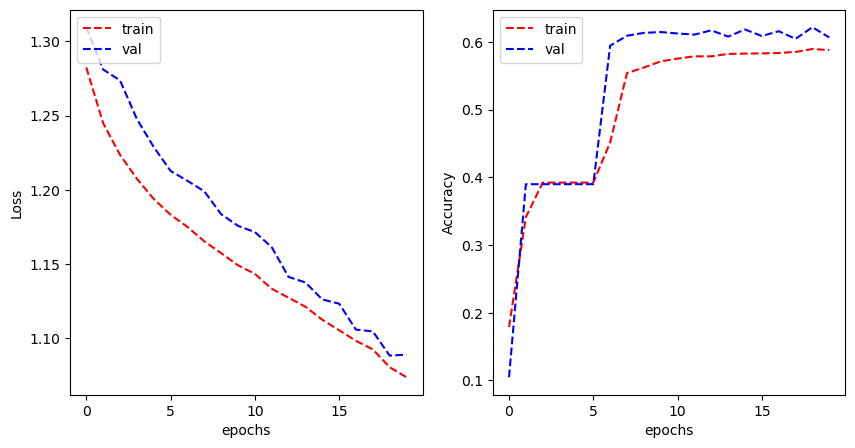

In [66]:
def transfer_model(model):
    # Freeze the layers except the last 4 layers (dense layers)
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:-4]:
        layer.trainable = False
    
    # replace the isCancerous output layer with the cellTypeName output layer
    model.layers.pop()
    transfer_model = Sequential()
    transfer_model.add(model)
    transfer_model.add(Dense(units=4, activation='softmax'))

    transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # # View the structure of the model
    transfer_model.summary()
    return transfer_model

# Create new generators for 'cellTypeName' prediction
y_col = 'cellTypeName'
transfer = transfer_model(cancer_softmax)
train_generator, val_generator, test_generator = generator(batch_size, y_col)
transfer_history= transfer.fit(train_generator, epochs=20, validation_data=val_generator)
train_val_accuracy(transfer_history)


Observations:
- there is a disproportionate amount of isCancerous data in main data vs extra data. Simply using extra data would lead to most epithelial cells
- I unfroze more layers to allow more variability in training.
- I kept high dropout, this encourages the transfer model to evolve
 - these are typically active during training but not during validation/testing. This means the model might perform better on the validation set because it's effectively a "full-strength" version of your model, while during training the model is "weaker" due to dropout.
I increased the epochs as I noticed while the accuracy was stagnating, the loss was constantly decreasing.

Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
19/19 [==============================] - 1s 60ms/step


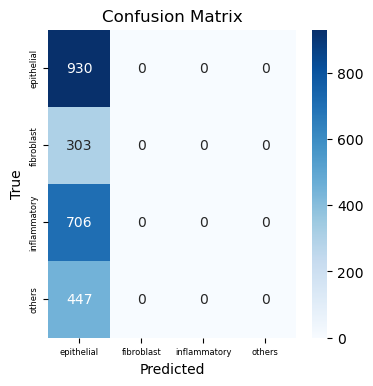

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

In [72]:
# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)

plot_metrics(val_generator, cancer_softmax, y_col)
cancer_softmax_scores = plot_metrics(test_generator, cancer_softmax, y_col)

[[0.5971341357472556, 0.8163920734950084], [0.6421982199554027, 0.8468683455891957], [0.6024071483894664, 0.8178491526361693], [0.3366616853524968, 0.6571838850586922]]


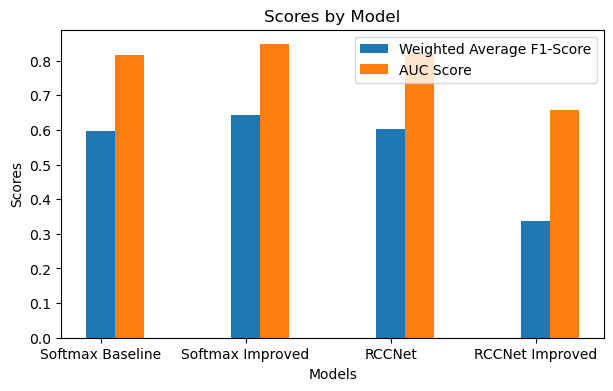

In [102]:
def plot_scores(models, score_categories, all_scores):
    plt.figure(figsize=(7,4))
    bar_width = 0.2

    for i, category in enumerate(score_categories):
        scores = [scores[i] for scores in all_scores]
        plt.bar(np.arange(len(models)) + i*bar_width, scores, width=bar_width, label=category)

    plt.title('Scores by Model')
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.xticks(np.arange(len(models)), models)
    plt.legend()
    plt.show()

# Plot the cell type model scores
models = ['Softmax Baseline', 'Softmax Improved', 'RCCNet', 'RCCNet Improved']
scores = [baseline_scores, cnn_improved_scores, rcc_scores, rcc_improved_scores]
score_categories = ['Weighted Average F1-Score', 'AUC Score']
plot_scores(models, score_categories, scores)

# Plot the is cancerous model scores
models = ['Softmax Baseline', 'Softmax Improved', 'RCCNet', 'RCCNet Improved']
scores = [baseline_scores, cnn_improved_scores, rcc_scores, rcc_improved_scores]
score_categories = ['Weighted Average F1-Score', 'AUC Score']
plot_scores(models, score_categories, scores)